# Capstone Project for the Data Science Specialization

### Rafael Y. Imai - April 2021

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.cluster import KMeans
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns

In [2]:
#historicSeries = pd.DataFrame()
#for year in range(2017,2021):
#    for month in range(1,13):
#        file = "CVMData/inf_diario_fi_{0}{1}.csv".format(year,str(month).zfill(2))
#        historicSeries = historicSeries.append(pd.read_csv(file, sep = ";"))
#    print("{} inserted.".format(year))

#historicSeries=historicSeries[["CNPJ_FUNDO","DT_COMPTC","VL_TOTAL","VL_QUOTA","VL_PATRIM_LIQ","CAPTC_DIA","RESG_DIA","NR_COTST"]]
#historicSeries['CAP_LIQ']=historicSeries['CAPTC_DIA']-historicSeries['RESG_DIA']
#historicSeries['TKT_MED']=historicSeries['VL_PATRIM_LIQ']/historicSeries['NR_COTST']

Also, let's load a dataset with all of the investment funds that have existed since the early 90's in Brazil. This file was also obtained from CVM.

In [3]:
#firstFundFilterLayer = fundList[((fundList["TP_FUNDO"]=="FI")
#                                 &(((fundList["DT_REG"]<="2017-01-01")&((fundList["DT_CANCEL"]>="2020-12-31")))
#                                   |((fundList["DT_REG"]<="2017-01-01")&(fundList["SIT"]=="EM FUNCIONAMENTO NORMAL"))))]
fundList = pd.read_excel("cad_fi.xlsx")


firstFundFilterLayer = fundList[fundList["TP_FUNDO"]=="FI"]
firstFundFilterLayer = firstFundFilterLayer[firstFundFilterLayer["DT_REG"]<"2017-01-01"]
firstFundFilterLayer = firstFundFilterLayer.drop_duplicates(subset=['CNPJ_FUNDO'], keep='last')
         

#### Another dataset that we will use is the historic series of the IBOVESPA index, the stock market index for the São Paulo Stock Exchange.

In [4]:
#ibov = yf.Ticker('^BVSP')
#ibovHistoric = ibov.history(start="2017-01-02",  end="2020-12-31")
#ibovHistoricClose = ibovHistoric[["Close"]] 
#ibovHistoricClose = ibovHistoricClose.rename(columns={'Date':'DATE',"Close":"CLOSE"}) 

In [5]:
#selicData = pd.read_json("http://api.bcb.gov.br/dados/serie/bcdata.sgs.4189/dados?formato=json&dataInicial=01/01/2017&dataFinal=31/12/2020")
#selicData.head()
#selicData["data"]=pd.to_datetime(selicData.data)
#selicData = selicData.set_index("data")
 

In [6]:
insightsIhfa_Dump=pd.read_csv("ihfa_dump_2017-01-01-2020-12-31.csv")
insightsFI_Dump=pd.read_csv("fixedIncome_dump_2017-01-01-2020-12-31.csv")
insightsInterbankRate_Dump=pd.read_csv("interbankRate_dump_2017-01-01-2020-12-31.csv")
insightsPrivateBond_Dump=pd.read_csv("privateBond_dump_2017-01-01-2020-12-31.csv")


In [7]:
insightsIhfa_Dump=insightsIhfa_Dump[['CNPJ','IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']]
insightsFI_Dump=insightsFI_Dump[['CNPJ','IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']]
insightsInterbankRate_Dump=insightsInterbankRate_Dump[['CNPJ','IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']]
insightsPrivateBond_Dump=insightsPrivateBond_Dump[['CNPJ','IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']]

insightsIhfa_Dump=insightsIhfa_Dump.set_index("CNPJ")
insightsFI_Dump=insightsFI_Dump.set_index("CNPJ")
insightsInterbankRate_Dump=insightsInterbankRate_Dump.set_index("CNPJ")
insightsPrivateBond_Dump=insightsPrivateBond_Dump.set_index("CNPJ")

In [8]:
def plot_wordcloud(parsed, clusterCount, graphTitle,stopwordsClass):

    stopwords = set(STOPWORDS)
    stopwords.update(["INVESTIMENTO", "COTAS", "QUOTAS", "DE", "FUNDO", "FEEDER", "EM", "FDO", "INV", "FDOS", 
                      "INVES","FUNDOS","FICFI","FI"])
    stopwords.update(stopwordsClass)


    for i in range(0,clusterCount):    
        consolidated = parsed[parsed['resultKmeans']==i]
        consolidated = consolidated['DENOM_SOCIAL']

        text = ""
        for a in consolidated:
            text = text + " " + a


        wordcloud = WordCloud(stopwords=stopwords,max_font_size=50, max_words=20, background_color="white").generate(text)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title("{} - Cluster #{}".format(graphTitle,i+1))
        plt.savefig("{}_{}.png".format(graphTitle,i+1))
        plt.show()

In [9]:
def test_kmeans(maxClusters,data):

    wcss=[]

    for i in range(1,maxClusters):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data[['IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']].dropna())    
        wcss = wcss + [kmeans.inertia_] 
    plt.plot(range(1,20),wcss) 
    
    
    

In [10]:
def run_kmeans(clusterCount,data):

    kmeans = KMeans(n_clusters=clusterCount, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data[['IbovCorrelation','SELICCorrelation','flowCorrelation','avgTicketCorrelation','vol']].dropna())

    k_means_labels = kmeans.labels_
    k_means_cluster_centers = kmeans.cluster_centers_

    print("Centroids:")
    print(k_means_cluster_centers)

    return k_means_labels, k_means_cluster_centers


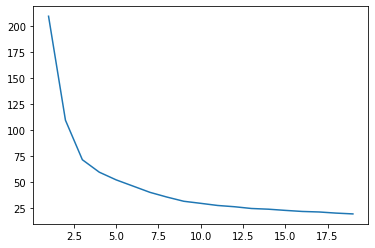

In [11]:
test_kmeans(20,insightsIhfa_Dump)

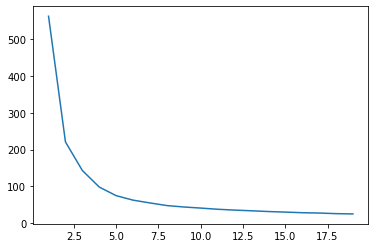

In [12]:
test_kmeans(20,insightsFI_Dump)

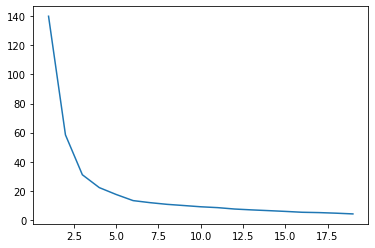

In [13]:
test_kmeans(20,insightsInterbankRate_Dump)

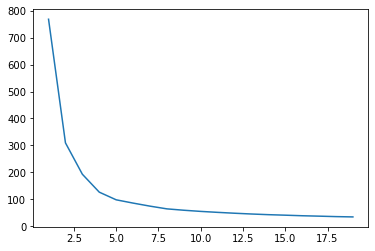

In [14]:
test_kmeans(20,insightsPrivateBond_Dump)

In [15]:
stopwordsClassIhfa = ['MULTIMERCADO', 'HEDGE', 'ADVISORY']
clusterCountIhfa = 5
k_means_labels_ihfa, k_means_cluster_centers_ihfa = run_kmeans(clusterCountIhfa, insightsIhfa_Dump)

stopwordsFI = ['RF','RENDA FIXA', 'RENDA', 'FIXA','ADVISORY']
clusterCountFI = 3
k_means_labels_FI, k_means_cluster_centers_FI = run_kmeans(clusterCountFI, insightsFI_Dump)

stopwordsInterbank = ['REFERENCIADO', 'DI', 'REFERENCIADO DI','RF','RENDA FIXA', 'RENDA', 'FIXA','ADVISORY']
clusterInterbank = 3
k_means_labels_Interbank, k_means_cluster_centers_Interbank = run_kmeans(clusterInterbank, insightsInterbankRate_Dump)

stopwordsClassPB = ['CRED', 'PRIV', 'CP', 'CREDITO PRIVADO','CRÉDITO PRIVADO','CRÉDITO', 'PRIVADO','RF','RENDA FIXA', 'RENDA', 'FIXA','ADVISORY']
clusterCountPB = 3
k_means_labels_PB, k_means_cluster_centers_PB = run_kmeans(3, insightsPrivateBond_Dump)

Centroids:
[[-0.03115253 -0.68010393 -0.09704139 -0.28812077  0.07936551]
 [ 0.04172778  0.63867494 -0.03588784 -0.3546839   0.0985064 ]
 [-0.7254457   0.64084684  0.0176389  -0.29192732  0.09284521]
 [ 0.47930459 -0.77933124 -0.0543051   0.58510361  0.10879469]
 [ 0.56609586 -0.77598108  0.00876602 -0.59909958  0.12317688]]
Centroids:
[[ 0.5158623  -0.70449364 -0.02609729 -0.18662258  0.07511105]
 [-0.66482882  0.62961463 -0.01792156  0.68304923  0.06320346]
 [-0.66181984  0.62429896  0.00175394 -0.50175142  0.06286407]]
Centroids:
[[-0.71380333  0.71957389 -0.033292    0.74078601  0.05548687]
 [ 0.3972559  -0.6852683  -0.06557237 -0.17659654  0.06187598]
 [-0.70792783  0.71416221 -0.02867433 -0.65429393  0.05662903]]
Centroids:
[[-0.64170501  0.64089732  0.00463679 -0.61385052  0.0776298 ]
 [ 0.52356419 -0.70438568 -0.02137043 -0.22020869  0.08592032]
 [-0.66148236  0.62783313 -0.01999689  0.64085201  0.06527813]]


In [16]:
def print_wordcloud(dataSource,k_means_labels,clusterCount,title,stopwordsClass):
    transposed = pd.DataFrame(data=k_means_labels)
    parsed = dataSource.dropna().reset_index().join(transposed)
    parsed = parsed.set_index("CNPJ")
    parsed = parsed.rename(columns={0:"resultKmeans"})
    lista_interpretada = firstFundFilterLayer[["CNPJ_FUNDO","DENOM_SOCIAL"]].set_index("CNPJ_FUNDO")
    lista_interpretada=lista_interpretada.reset_index().rename(columns={"CNPJ_FUNDO":"CNPJ"}).set_index("CNPJ") 
    parsed = parsed.join(lista_interpretada) 
    plot_wordcloud(parsed, clusterCount, title,stopwordsClass)
    print("{} Shape".format(title))
    print(parsed.shape)
 

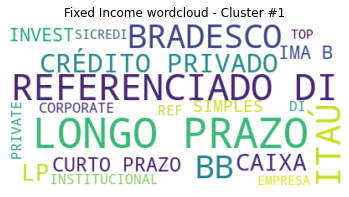

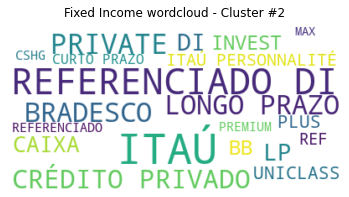

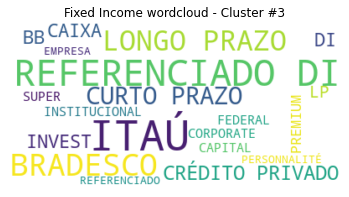

Fixed Income wordcloud Shape
(417, 7)


In [17]:
print_wordcloud(insightsFI_Dump,k_means_labels_FI,clusterCountFI,"Fixed Income wordcloud",stopwordsFI)

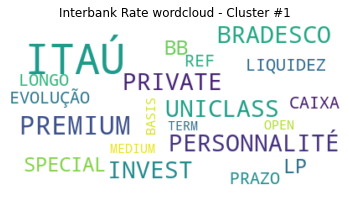

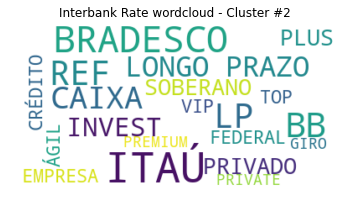

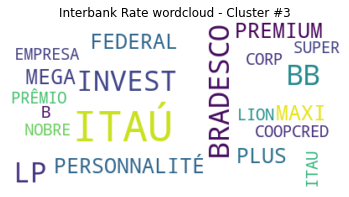

Interbank Rate wordcloud Shape
(101, 7)


In [18]:
print_wordcloud(insightsInterbankRate_Dump,k_means_labels_Interbank,clusterInterbank,"Interbank Rate wordcloud",stopwordsInterbank)

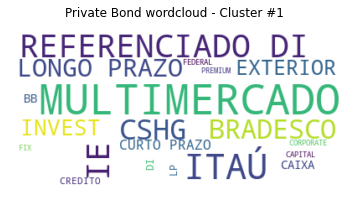

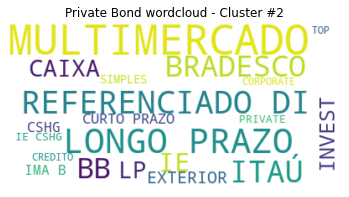

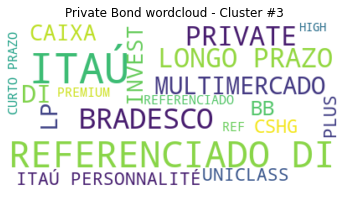

Private Bond wordcloud Shape
(566, 7)


In [19]:
print_wordcloud(insightsPrivateBond_Dump,k_means_labels_PB,clusterCountPB,"Private Bond wordcloud",stopwordsClassPB)

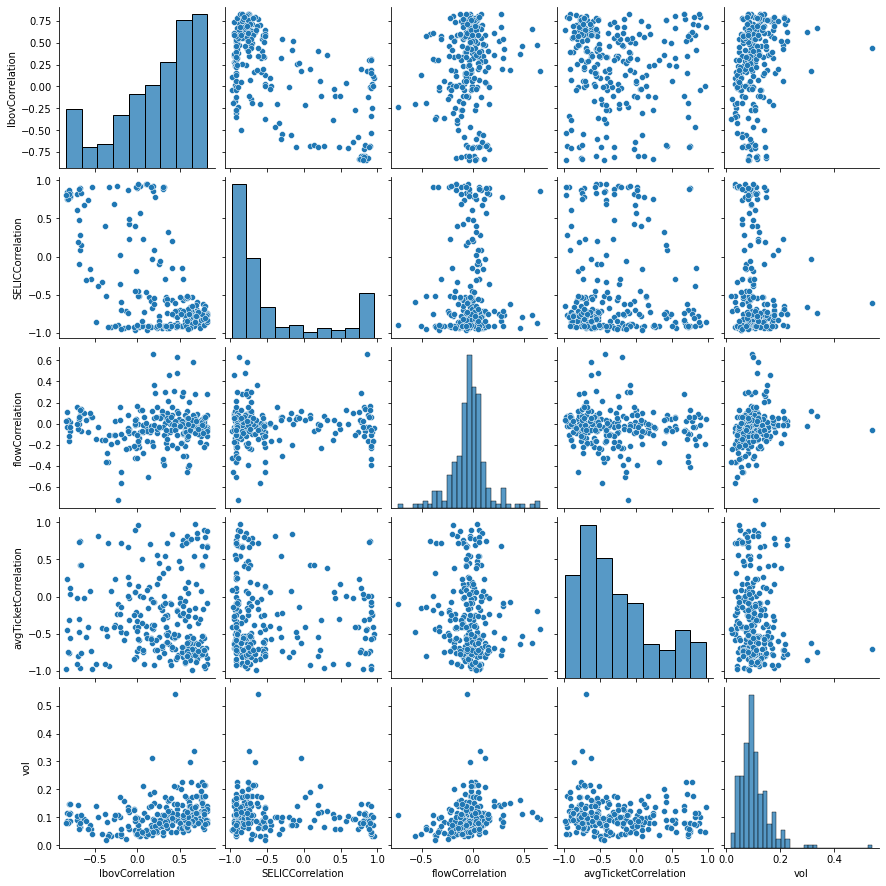

In [20]:
sns.pairplot(insightsIhfa_Dump)

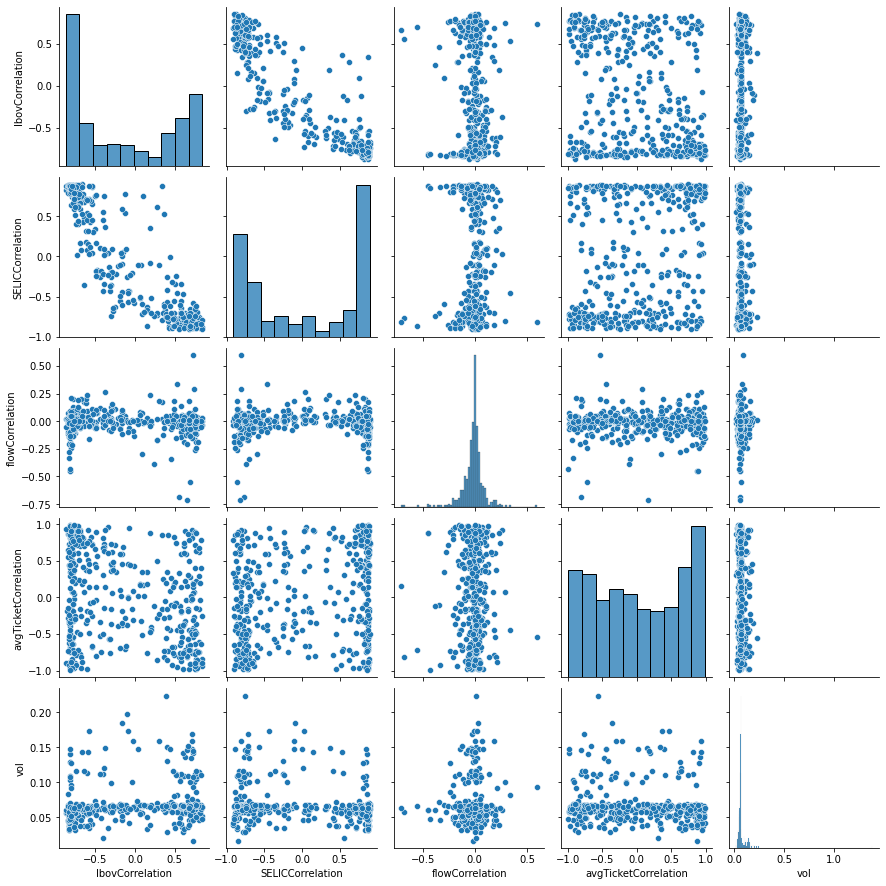

In [21]:
sns.pairplot(insightsFI_Dump)

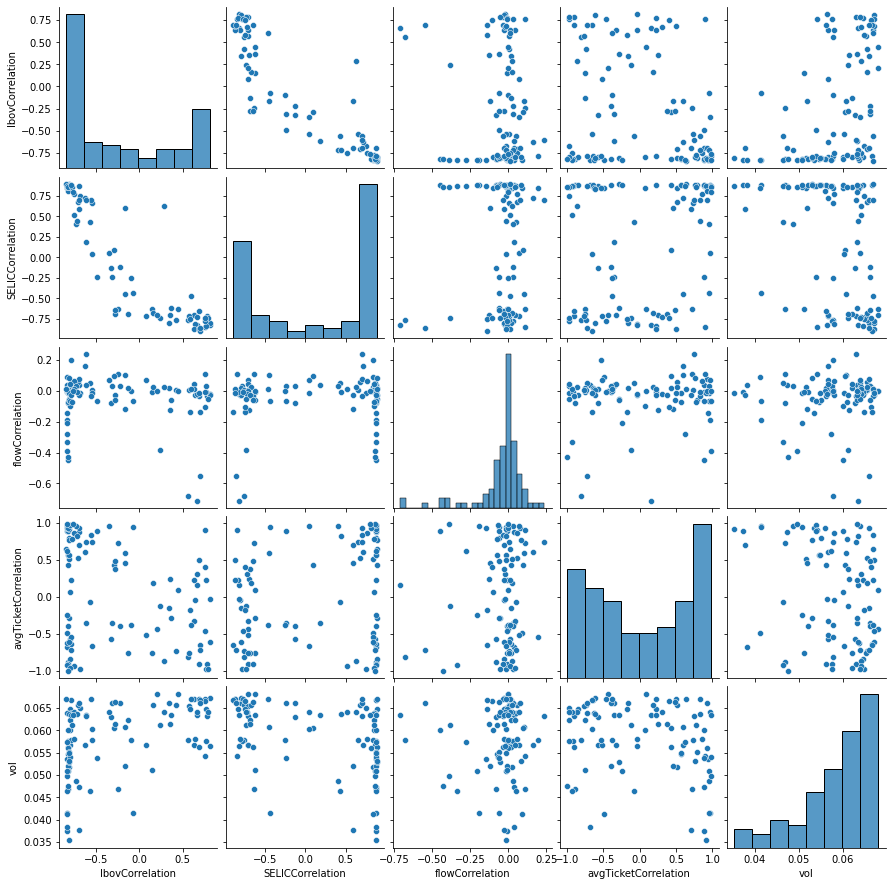

In [22]:
sns.pairplot(insightsInterbankRate_Dump)

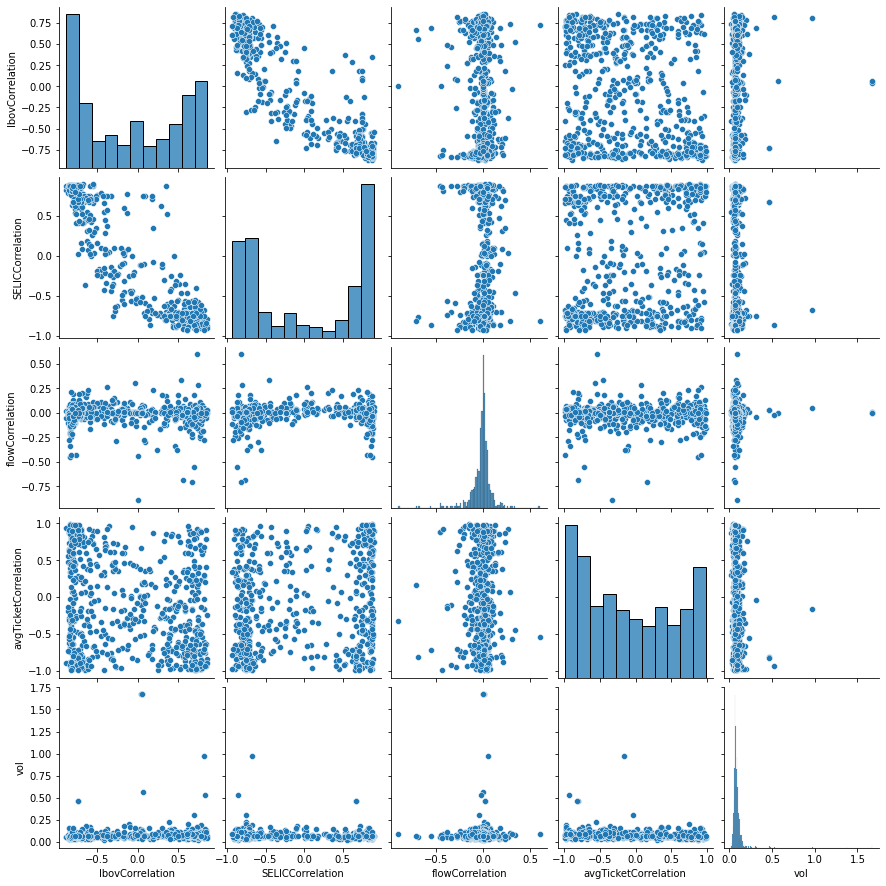

In [23]:
sns.pairplot(insightsPrivateBond_Dump)